## Implement Custom Prior For Fitting
To do this, you have to extend either `UniVarModel` or `MultiVarModel`.

In [1]:
import warnings

import arviz as az
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import optax
from eztao.carma import CARMA_term, DHO_term, DRW_term
from eztao.ts import addNoise, gpSimFull, gpSimRand
from eztaox.fitter import fit
from eztaox.initializers import CARMAInit, DRWInit, UniformInit
from eztaox.kernels import CARMA
from eztaox.models import MultiVarModel, UniVarModel
from eztaox.utils import formatlc
from numpyro.infer import ESS, MCMC, NUTS, SA, BarkerMH
from eztaox.kernel_utils import carma_sf, carma_psd
from functools import partial
from tinygp import kernels

warnings.filterwarnings(
    "ignore", category=RuntimeWarning
)  # Ignore ArviZ underflow warnings

jax.config.update("jax_enable_x64", True)

### 1. Simulate LC
- Added 5 day lag between g and i band

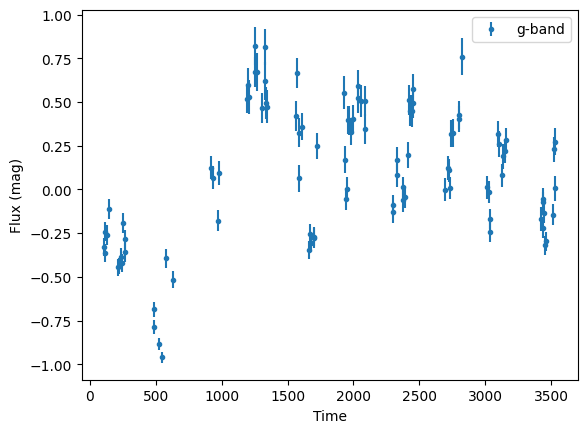

In [2]:
amps = {"g": 0.35, "i": 0.25}
taus = {"g": 100, "i": 150}
snrs = {"g": 5, "i": 3}
sampling_seeds = {"g": 2, "i": 5}
noise_seeds = {"g": 111, "i": 2}

ts, ys, yerrs = {}, {}, {}
ys_noisy = {}
seed = 2
for band in "gi":
    DRW_kernel = DRW_term(np.log(amps[band]), np.log(taus[band]))
    t, y, yerr = gpSimRand(
        DRW_kernel,
        snrs[band],
        365 * 10,
        100,
        lc_seed=seed,
    )

    # add to dict
    ts[band] = t
    ys[band] = y
    yerrs[band] = yerr
    # add simulated photometric noise
    ys_noisy[band] = addNoise(ys[band], yerrs[band], seed=noise_seeds[band] + seed)

for b in "g":
    plt.errorbar(
        ts[b][::1], ys_noisy[b][::1], yerrs[b][::1], fmt=".", label=f"{b}-band"
    )

plt.xlabel("Time")
plt.ylabel("Flux (mag)")
plt.legend()

### 2. Extend UniVarModel

In [3]:
class myModel(UniVarModel):

    # define your own prior for fitting; use DRW for demonstration
    def myPrior(self, params):

        prior = 0.0
        tau = params["log_kernel_param"][0]
        # return -inf is tau is smaller than 500 day and larger than 10 day
        prior += jax.lax.select(
            jnp.logical_and(tau >= jnp.log(10), tau <= jnp.log(500)), -jnp.inf, 0.0
        )

        return prior
    # also need to update the log_prob to include the prior
    def log_prob(self, params):
        gp = self._build_gp(params)
        return gp.log_probability(self.y[self.inds]) + self.myPrior(params)

#### 2.1 Fit Using the new model

In [4]:
# define params
zero_mean = False
has_jitter = True
p = 2
test_params = {"log_kernel_param": jnp.log(np.array([1 / 100.0, 0.35]))}

# define kernel
k = kernels.quasisep.Exp(*jnp.exp(test_params["log_kernel_param"]))

m = myModel(
    ts["g"], ys_noisy["g"], yerrs["g"], k, zero_mean=zero_mean, has_jitter=has_jitter
)
m

myModel(
  t=f64[100],
  y=f64[100],
  yerr=f64[100],
  inds=i64[100],
  kernel_def=<jax._src.util.HashablePartial object at 0xffff088c43b0>,
  zero_mean=False,
  has_jitter=True
)

In [5]:
# for CARMA kernel, the learning_rate needs to be larger
optimizer = optax.adam(learning_rate=1)


def initSampler(key, nSample):
    # split keys
    subkeys = jax.random.split(key, 10)

    # uniform sampler
    meanSampler = UniformInit(1, [-0.3, 0.3])
    logJitterSampler = UniformInit(1, [-20, -5])

    # kernel init
    kernelSampler = DRWInit([jnp.log(1 / 1000), jnp.log(1)], [jnp.log(0.05), 0.0])

    return {
        "log_kernel_param": kernelSampler(subkeys[0], nSample),
        "mean": meanSampler(subkeys[2], nSample),
        "log_jitter": logJitterSampler(subkeys[4], nSample),
    }


initSample = initSampler(jax.random.PRNGKey(10), 1)
initSample

{'log_kernel_param': Array([-2.85186501, -2.03368661], dtype=float64),
 'mean': Array(0.24264268, dtype=float64),
 'log_jitter': Array(-8.93528402, dtype=float64)}

In [6]:
optimizer = optax.adam(learning_rate=0.1)
initSampler = initSampler
prng_key = jax.random.PRNGKey(0)
nInitSample = 1_000
nIter = 2
nBest = 5
jaxoptMethod = "SLSQP"

bestP, logProb = fit(m, optimizer, initSampler, prng_key, nInitSample, nIter, nBest)
bestP, logProb

({'log_jitter': Array(-9.28405721, dtype=float64),
  'log_kernel_param': Array([ 6.21460928, -0.78179752], dtype=float64),
  'mean': Array(0.1366942, dtype=float64)},
 Array(12.81444206, dtype=float64, weak_type=True))

In [7]:
print(f'Best-fit Tau: {jnp.exp(bestP['log_kernel_param'][0])}')

Best-fit Tau: 500.0005927322352


### 3. Without Custom Prior

In [8]:
zero_mean = False
has_jitter = True
p = 2
test_params = {"log_kernel_param": jnp.log(np.array([1 / 100.0, 0.35]))}

# define kernel
k = kernels.quasisep.Exp(*jnp.exp(test_params["log_kernel_param"]))

m2 = UniVarModel(
    ts["g"], ys_noisy["g"], yerrs["g"], k, zero_mean=zero_mean, has_jitter=has_jitter
)
m2

UniVarModel(
  t=f64[100],
  y=f64[100],
  yerr=f64[100],
  inds=i64[100],
  kernel_def=<jax._src.util.HashablePartial object at 0xffff09190530>,
  zero_mean=False,
  has_jitter=True
)

In [9]:
optimizer = optax.adam(learning_rate=0.1)
initSampler = initSampler
prng_key = jax.random.PRNGKey(0)
nInitSample = 10_000
nIter = 2
nBest = 5
jaxoptMethod = "SLSQP"

bestP, logProb = fit(m2, optimizer, initSampler, prng_key, nInitSample, nIter, nBest)
bestP, logProb

({'log_jitter': Array(-19.51387019, dtype=float64),
  'log_kernel_param': Array([ 4.91283035, -0.9372493 ], dtype=float64),
  'mean': Array(0.07285778, dtype=float64)},
 Array(24.21248311, dtype=float64, weak_type=True))

In [10]:
print(f'Best-fit Tau: {jnp.exp(bestP['log_kernel_param'][0])}')

Best-fit Tau: 136.02386575435105
